In [39]:
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [41]:
import re

In [42]:
plt.rcParams['figure.figsize'] = (10, 8)

In [43]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [44]:
train['is_cap'] = train.Word.apply(lambda x: int(re.search(r'([А-Я]|Ё)', x[0]) is not None))
train['is_all_cap'] = train.Word.apply(lambda x: int(str(x).isupper()))
train['length'] = train.Word.apply(lambda x: len(str(x)))

In [45]:
endings_3 = train[train.Label == 1]['Word'].apply(lambda x: x[-3:].lower()).value_counts().to_dict()

In [46]:
sum_ = sum(endings_3.values())

In [47]:
for key in endings_3.keys():
    endings_3[key] /= (0.01 * sum_) 

In [48]:
endings_2 = train[train.Label == 1]['Word'].apply(lambda x: x[-2:].lower()).value_counts().to_dict()
sum_ = sum(endings_2.values())
for key in endings_2.keys():
    endings_2[key] /= (0.01 * sum_) 

In [49]:
begins_2 = train[train.Label == 1]['Word'].apply(lambda x: x[:2].lower()).value_counts().to_dict()
sum_ = sum(begins_2.values())
for key in begins_2.keys():
    begins_2[key] /= (0.01 * sum_) 

In [50]:
train.head()

,Word,Label,is_cap,is_all_cap,length
0,Аалтонен,1,1,0,8
1,Аар,0,1,0,3
2,Аарон,0,1,0,5
3,ААРОН,0,1,1,5
4,Аарона,0,1,0,6


In [14]:
# сделать 0

# train.loc[train[(train.Label == 1) & (train.is_cap == 0)].index] = 0

In [51]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [52]:
def get_value_of_ending(word, endings, length_ending):
    
    word = str(word)
    if len(word) < length_ending:
        return 0
    
    end = word[-length_ending:].lower()
    if end not in endings:
        return 0
    else:
        return endings[end]
    
def get_value_of_begins(word, begins, length_begining):
    
    word = str(word)
    if len(word) < length_begining:
        return 0
    
    start = word[:length_begining].lower()
    if start not in begins:
        return 0
    else:
        return begins[start]

In [53]:
train['begin_val_2'] = train.Word.apply(lambda x: get_value_of_begins(x, begins_2, 2))

train['end_val_2'] = train.Word.apply(lambda x: get_value_of_ending(x, endings_2, 2))
train['end_val_3'] = train.Word.apply(lambda x: get_value_of_ending(x, endings_3, 3))

In [54]:
train.head()

,Word,Label,is_cap,is_all_cap,length,begin_val_2,end_val_2,end_val_3
0,Аалтонен,1,1,0,8,0.018801,0.695619,0.028201
1,Аар,0,1,0,3,0.018801,0.122203,0.000000
2,Аарон,0,1,0,5,0.018801,2.011656,0.056402
3,ААРОН,0,1,1,5,0.018801,2.011656,0.056402
4,Аарона,0,1,0,6,0.018801,4.794134,1.344238


In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(train[['is_cap', 'is_all_cap', 
                                                             'end_val_2', 'end_val_3', 'begin_val_2']].values, 
                                                      train.Label.values,
                                                      test_size=.3, 
                                                      random_state=17)

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [26]:
clf = RandomForestClassifier(n_estimators=30, n_jobs=-1, oob_score=True)

In [27]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [28]:
pred = clf.predict(X_valid)

In [29]:
roc_auc_score(y_valid, pred)

0.69911358164150361

In [53]:
test.head()

,Word
0,Аалто
1,ААР
2,Аара
3,Ааре
4,Аарон


In [56]:
test['is_cap'] = test.Word.apply(lambda x: int(re.search(r'([А-Я]|Ё)', x[0]) is not None))
test['is_all_cap'] = test.Word.apply(lambda x: int(str(x).isupper()))
test['begin_val_2'] = test.Word.apply(lambda x: get_value_of_begins(x, begins_2, 2))
test['length'] = test.Word.apply(lambda x: len(str(x)))

test['end_val_2'] = test.Word.apply(lambda x: get_value_of_ending(x, endings_2, 2))
test['end_val_3'] = test.Word.apply(lambda x: get_value_of_ending(x, endings_3, 3))

In [56]:
test.head()

,Word,is_cap,is_all_cap,begin_val_2,end_val_2,end_val_3
0,Аалто,1,0,0.018801,0.169205,0.000000
1,ААР,1,1,0.018801,0.122203,0.000000
2,Аара,1,0,0.018801,2.340666,0.178605
3,Ааре,1,0,0.018801,0.629818,0.037601
4,Аарон,1,0,0.018801,2.011656,0.056402


In [57]:
rfc = RandomForestClassifier(n_jobs=-1, max_features='sqrt')

In [58]:
params = {
    'n_estimators': [5, 10, 15, 20, 25],
    'max_features': [2, 3]
}

In [59]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=params, cv= 10, scoring='roc_auc')

In [51]:
train.columns

Index(['Word', 'Label', 'is_cap', 'is_all_cap', 'begin_val_2', 'end_val_2',
       'end_val_3'],
      dtype='object')

In [61]:
CV_rfc.fit(train[train.columns.difference(['Word', 'Label'])], train.Label)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 15, 20, 25], 'max_features': [2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [62]:
CV_rfc.best_params_

{'max_features': 3, 'n_estimators': 25}

In [63]:
pred = CV_rfc.predict(test[test.columns.difference(['Word'])])

In [70]:
pd.DataFrame(list(zip(range(len(pred)), pred)), columns=['Id', 'Prediction']).to_csv('ans.txt', index=False, sep=',')

In [57]:
import xgboost as xgb

In [58]:
X_train, X_valid, y_train, y_valid = train_test_split(train[train.columns.difference(['Word', 'Label'])].values, 
                                                      train.Label.values,
                                                      test_size=.3, 
                                                      random_state=17)

In [59]:
d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_valid, label=y_valid)

In [31]:
pd.set_option.max_columns = None
pd.set_option.max_rows = None

In [60]:
print('Training ...')

params = {'max_depth': 10, 
          'min_child_weight': 50, 
          #'subsample': 0.9,
          #'colsample_bytree': 0.7,  
          #'colsample_bylevel': 0.7,
          'lambda': 0.1,
          'alpha': 0.1,
          'eta': 0.5, 
          'objective': 'binary:logistic',
          'eval_metric' : 'auc',
          'silent': 1,
          'seed': 17
         }

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model1 = xgb.train(params, d_train, 30000, watchlist, early_stopping_rounds=100, verbose_eval=10)
d_train_full = xgb.DMatrix(train[train.columns.difference(['Word', 'Label'])], label=train['Label'])
# print('AUC XgBoost: ', roc_auc_score(train['Label'], model1.predict(d_train_full)))

Training ...
[0]	train-auc:0.895723	valid-auc:0.88986
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[10]	train-auc:0.915245	valid-auc:0.907443
[20]	train-auc:0.921777	valid-auc:0.911949
[30]	train-auc:0.925375	valid-auc:0.913639
[40]	train-auc:0.928658	valid-auc:0.914884
[50]	train-auc:0.931141	valid-auc:0.914758
[60]	train-auc:0.933061	valid-auc:0.914853
[70]	train-auc:0.935164	valid-auc:0.915955
[80]	train-auc:0.93661	valid-auc:0.916299
[90]	train-auc:0.938437	valid-auc:0.916311
[100]	train-auc:0.939495	valid-auc:0.916422
[110]	train-auc:0.940909	valid-auc:0.915984
[120]	train-auc:0.942175	valid-auc:0.916354
[130]	train-auc:0.943278	valid-auc:0.916163
[140]	train-auc:0.944227	valid-auc:0.915967
[150]	train-auc:0.945064	valid-auc:0.915865
[160]	train-auc:0.945914	valid-auc:0.915644
[170]	train-auc:0.946776	valid-auc:0.915366
[180]	train-auc:0.947536	valid-auc:0.915526
Stopping. Best itera

In [65]:
x_test = test[test.columns.difference(['Word'])].copy()
x_test.columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5']
d_test = xgb.DMatrix(x_test)

In [67]:
sub = pd.read_csv('sample_submission.csv')


In [68]:
sub = sub.reset_index(drop=True)
sub.head()

,Id,Prediction
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [69]:
sub['Prediction'] = model1.predict(d_test)


In [70]:
sub

,Id,Prediction
0,0,0.001373
1,1,0.038447
2,2,0.424295
3,3,0.023545
4,4,0.277374
5,5,0.205806
6,6,0.320913
7,7,0.155622
8,8,0.155622
9,9,0.471868


In [71]:
sub.to_csv('submission_easy_xgb_2.csv', columns=['Id', 'Prediction'], index=False)


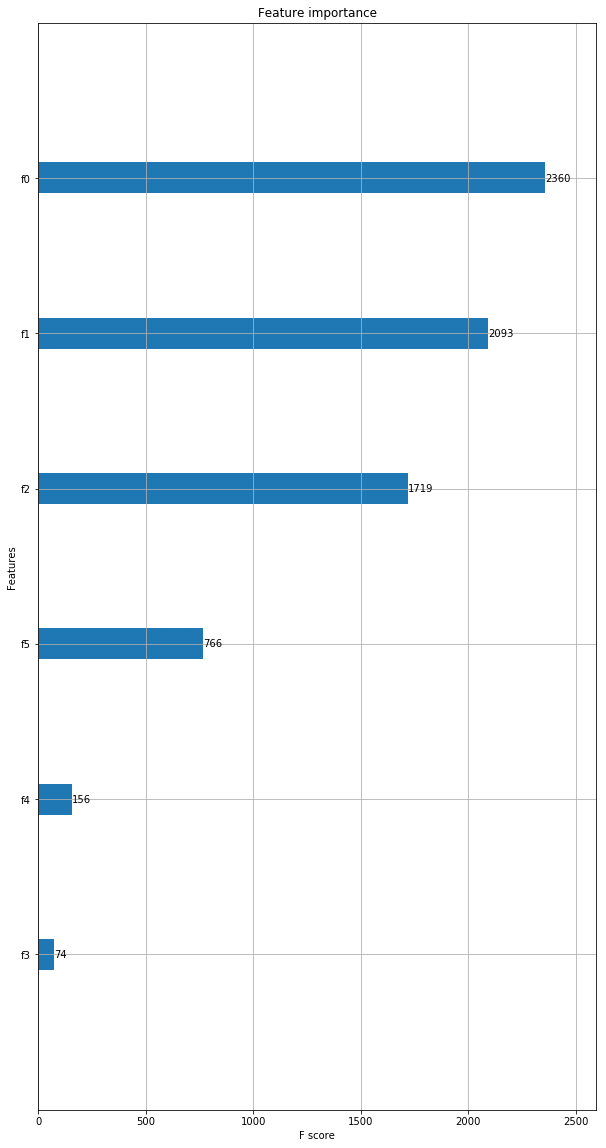

In [72]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)
%matplotlib inline
my_plot_importance(model1, (10,20))